In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
# Load the data
train_df = pd.read_csv('/Masters/ANN/Assignment/IMDB Movie Review/train.tsv', sep='\t')
test_df = pd.read_csv('/Masters/ANN/Assignment/IMDB Movie Review/test.tsv', sep='\t')

In [3]:
# Load stopwords
with open('/Masters/ANN/Assignment/IMDB Movie Review/stopwords.txt', 'r') as f:
    stopwords = set(f.read().splitlines())

In [4]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nhyuj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nhyuj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nhyuj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [6]:
# Function to get the part of speech tag for lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

In [7]:
# Text preprocessing function
def preprocess_text(text):
    # Remove special characters and lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words if word not in stopwords]
    return ' '.join(words)

In [8]:
example = "I don't like this movie, it doesn't make sense. he won't watch it again in 2024 @ !"
print(preprocess_text(example))

dont like doesnt make sense wont watch


In [9]:
from tqdm import tqdm
tqdm.pandas()

# Apply preprocessing
train_df['cleaned_review'] = train_df['review'].progress_apply(preprocess_text)
test_df['cleaned_review'] = test_df['review'].progress_apply(preprocess_text)

100%|██████████████████████████████████████████████████████████████████████████████| 2681/2681 [01:06<00:00, 40.42it/s]


In [10]:
# Tokenize the cleaned reviews
tokenizer = Tokenizer(num_words=10000)  # Use the top 10,000 words
tokenizer.fit_on_texts(train_df['cleaned_review'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_review'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_review'])

# Define maximum sequence length
max_length = 200

# Pad the sequences to ensure uniform length
X_train = pad_sequences(train_sequences, maxlen=max_length)
X_test = pad_sequences(test_sequences, maxlen=max_length)

In [11]:
# Encode sentiment labels to integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sentiment'])
y_test = label_encoder.transform(test_df['sentiment'])

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [12]:
# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(len(word_index) + 1, 10000)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= 10000:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
# Define the model with a single LSTM layer
model = Sequential([
    Embedding(input_dim=num_words, 
              output_dim=embedding_dim,  
              weights=[embedding_matrix], 
              trainable=False),
    LSTM(64),
    Dropout(0.7),
    Dense(3, activation='softmax')  # Output layer with 3 classes
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [13]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.4)

Epoch 1/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4311 - loss: 1.0573 - val_accuracy: 0.5572 - val_loss: 0.9153
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.5471 - loss: 0.9340 - val_accuracy: 0.5769 - val_loss: 0.8870
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.5729 - loss: 0.8898 - val_accuracy: 0.5705 - val_loss: 0.8869
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.5832 - loss: 0.8762 - val_accuracy: 0.6013 - val_loss: 0.8496
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.6018 - loss: 0.8508 - val_accuracy: 0.6115 - val_loss: 0.8300
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - accuracy: 0.6096 - loss: 0.8366 - val_accuracy: 0.6173 - val_loss: 0.8198
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.6252 - loss: 0.8221 - val_accuracy: 0.6215 - val_loss: 0.8126
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.6260 - loss: 0.8111 -

In [14]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5208 - loss: 1.4994
Test Accuracy: 0.5144


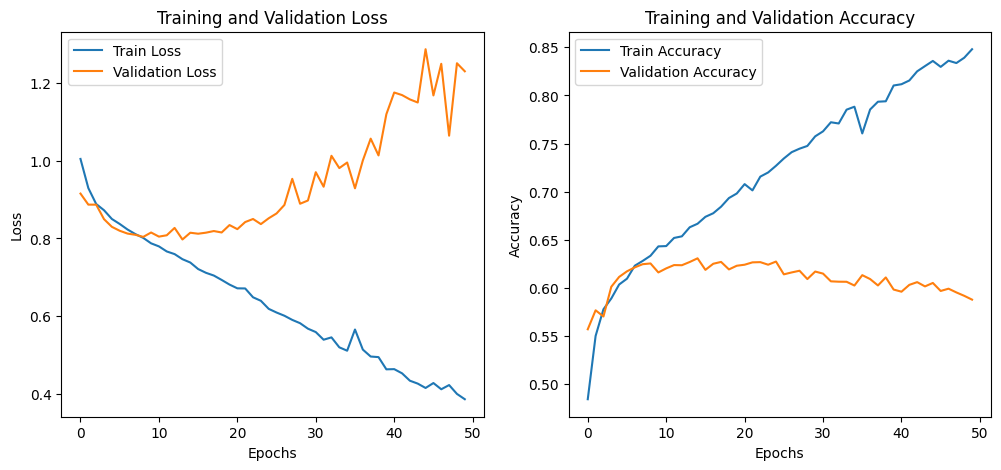

In [15]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training & validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
# Predict sentiment for new reviews
new_reviews = ["This movie was fantastic! I loved it.", "The plot was boring and predictable.", "The movie was alright. I didn't like the romance but the action was okay."]
new_sequences = tokenizer.texts_to_sequences(new_reviews)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length)

# Predict the sentiments
predictions = model.predict(new_padded_sequences)
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
[2 0 1]
